In [1]:
using ReactiveMP, Rocket, GraphPPL
using Random, LinearAlgebra, Plots, Flux, DataFrames, DelimitedFiles

In [2]:
sensors = readdlm("data/sensor_fusion/sensors.txt")
sensor1, sensor2, sensor3 = sensors[1,:], sensors[2,:], sensors[3,:]
observation = readdlm("data/sensor_fusion/observation.txt")
position = readdlm("data/sensor_fusion/position.txt")
T = 15
observation_list = [observation[t,:] for t=1:T];

In [4]:
A = [1.0 0.0 1.0 0.0; 0.0 1.0 0.0 1.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
B = [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0]
# Nonlinear function that maps states to observations
function f(z)       
    pos = B*z
    o1 = sqrt(sum((pos-sensor1).^2))
    o2 = sqrt(sum((pos-sensor2).^2))
    o3 = sqrt(sum((pos-sensor3).^2))
    o = [o1,o2,o3]
end

@model function sensor_fusion(T)
    W = diagm(0=>ones(4))
    R = diagm(0=>ones(3))

    z = randomvar(T)
    x = randomvar(T)
    y = datavar(Vector{Float64}, T)

    z[1] ~ MvNormalMeanCovariance(zeros(4), diagm(0 => ones(4)))
    x[1] ~ f(z[1]) where {meta = CVIApproximation(2000, 100, Descent(0.1))}
    y[1] ~ MvNormalMeanCovariance(x[1], diagm(0 => ones(3)))

    for t in 2:T
        z[t] ~ MvNormalMeanPrecision(A * z[t-1], W)
        x[t] ~ f(z[t]) where {meta = CVIApproximation(2000, 100, Descent(0.1))}
        y[t] ~ MvNormalMeanPrecision(x[t], R)
    end

    return z, x, y
end

constraints = @constraints begin
    q(z, x) = q(z)q(x)
end;

In [5]:
res = inference(
    model = Model(sensor_fusion, T),
    data = (y = observation_list,),
    iterations = 1,
    free_energy = false,
    returnvars = (z = KeepEach(),),
    constraints = constraints,
    initmessages = (z = MvNormalMeanPrecision(zeros(4), 0.01*diagm(0=>ones(4))),),
)

Inference results:
-----------------------------------------
z = Vector{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}...


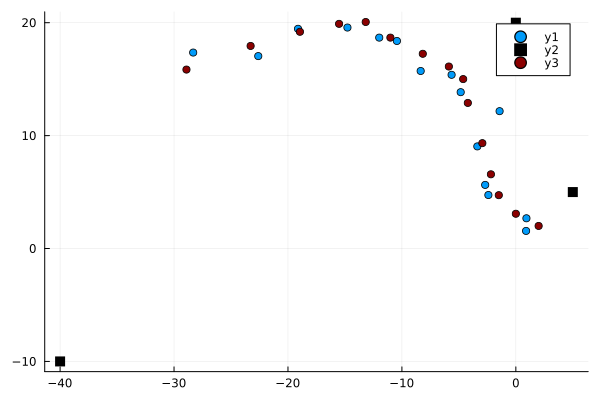

In [6]:
points = map(z -> mean(z)[1:2], res.posteriors[:z][1]);
x = map(z -> z[1], points);
y = map(z -> z[2], points);
plot(x, y, seriestype = :scatter)
plot!([sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]],
    seriestype = :scatter, color=:black, markersize=5, markershape=:square)
plot!(position'[1:15, 1], position'[1:15, 2], seriestype = :scatter, color=:redsblues)